<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


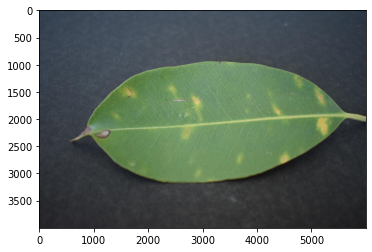

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

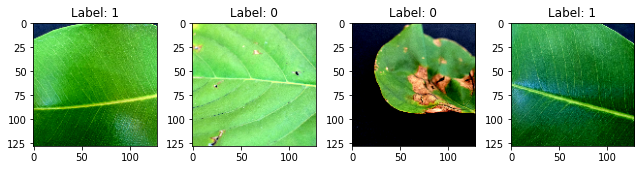

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2459303560855344 samples/sec                   batch loss = 0.3872365355491638 | accuracy = 0.6


Epoch[1] Batch[10] Speed: 1.2644145701008127 samples/sec                   batch loss = 0.7952698469161987 | accuracy = 0.55


Epoch[1] Batch[15] Speed: 1.2635229748176042 samples/sec                   batch loss = 0.5786567330360413 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2635285891785746 samples/sec                   batch loss = 0.4552178680896759 | accuracy = 0.525


Epoch[1] Batch[25] Speed: 1.2328437636632852 samples/sec                   batch loss = 0.7509827613830566 | accuracy = 0.56


Epoch[1] Batch[30] Speed: 1.262583795517189 samples/sec                   batch loss = 1.0014442205429077 | accuracy = 0.5666666666666667


Epoch[1] Batch[35] Speed: 1.2565366664392343 samples/sec                   batch loss = 0.8442575335502625 | accuracy = 0.5642857142857143


Epoch[1] Batch[40] Speed: 1.263142741799842 samples/sec                   batch loss = 0.6647330522537231 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.261271173870725 samples/sec                   batch loss = 0.6772591471672058 | accuracy = 0.5944444444444444


Epoch[1] Batch[50] Speed: 1.2711801403561198 samples/sec                   batch loss = 0.4121902883052826 | accuracy = 0.605


Epoch[1] Batch[55] Speed: 1.2666369760373368 samples/sec                   batch loss = 0.3637653589248657 | accuracy = 0.6090909090909091


Epoch[1] Batch[60] Speed: 1.2679553336609806 samples/sec                   batch loss = 0.38575807213783264 | accuracy = 0.6166666666666667


Epoch[1] Batch[65] Speed: 1.2696528792377912 samples/sec                   batch loss = 0.37625548243522644 | accuracy = 0.6038461538461538


Epoch[1] Batch[70] Speed: 1.2667133873051841 samples/sec                   batch loss = 0.8728159666061401 | accuracy = 0.6035714285714285


Epoch[1] Batch[75] Speed: 1.2703804580337639 samples/sec                   batch loss = 0.3298029601573944 | accuracy = 0.62


Epoch[1] Batch[80] Speed: 1.2596013428467285 samples/sec                   batch loss = 0.2891830801963806 | accuracy = 0.628125


Epoch[1] Batch[85] Speed: 1.265581837290077 samples/sec                   batch loss = 0.36459192633628845 | accuracy = 0.6352941176470588


Epoch[1] Batch[90] Speed: 1.2589850581401676 samples/sec                   batch loss = 0.47592201828956604 | accuracy = 0.6416666666666667


Epoch[1] Batch[95] Speed: 1.2658022171964 samples/sec                   batch loss = 0.7019261121749878 | accuracy = 0.6421052631578947


Epoch[1] Batch[100] Speed: 1.2623848616292914 samples/sec                   batch loss = 0.4996486008167267 | accuracy = 0.6475


Epoch[1] Batch[105] Speed: 1.2652820414392068 samples/sec                   batch loss = 0.9747634530067444 | accuracy = 0.6428571428571429


Epoch[1] Batch[110] Speed: 1.2671025679020624 samples/sec                   batch loss = 0.8100388050079346 | accuracy = 0.6431818181818182


Epoch[1] Batch[115] Speed: 1.2640020878330385 samples/sec                   batch loss = 1.025850772857666 | accuracy = 0.6434782608695652


Epoch[1] Batch[120] Speed: 1.2720166090158485 samples/sec                   batch loss = 0.30440807342529297 | accuracy = 0.64375


Epoch[1] Batch[125] Speed: 1.2779753754675611 samples/sec                   batch loss = 0.4902743399143219 | accuracy = 0.646


Epoch[1] Batch[130] Speed: 1.2736189815597498 samples/sec                   batch loss = 0.8182705044746399 | accuracy = 0.6423076923076924


Epoch[1] Batch[135] Speed: 1.263539532567939 samples/sec                   batch loss = 0.7097350358963013 | accuracy = 0.6444444444444445


Epoch[1] Batch[140] Speed: 1.2639958978862376 samples/sec                   batch loss = 0.8042882084846497 | accuracy = 0.6428571428571429


Epoch[1] Batch[145] Speed: 1.2615936421371814 samples/sec                   batch loss = 1.331424593925476 | accuracy = 0.6396551724137931


Epoch[1] Batch[150] Speed: 1.2672985880797059 samples/sec                   batch loss = 0.49285104870796204 | accuracy = 0.6383333333333333


Epoch[1] Batch[155] Speed: 1.2668587758724088 samples/sec                   batch loss = 0.483171284198761 | accuracy = 0.6370967741935484


Epoch[1] Batch[160] Speed: 1.2674987864971603 samples/sec                   batch loss = 0.387315958738327 | accuracy = 0.640625


Epoch[1] Batch[165] Speed: 1.251299688122584 samples/sec                   batch loss = 1.026482105255127 | accuracy = 0.6409090909090909


Epoch[1] Batch[170] Speed: 1.2669918547904204 samples/sec                   batch loss = 0.3999928832054138 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.265161533189834 samples/sec                   batch loss = 0.8429444432258606 | accuracy = 0.6428571428571429


Epoch[1] Batch[180] Speed: 1.2659228475344324 samples/sec                   batch loss = 0.549750566482544 | accuracy = 0.6430555555555556


Epoch[1] Batch[185] Speed: 1.265248930393125 samples/sec                   batch loss = 0.6025580763816833 | accuracy = 0.6472972972972973


Epoch[1] Batch[190] Speed: 1.268517224755645 samples/sec                   batch loss = 0.6362119913101196 | accuracy = 0.6526315789473685


Epoch[1] Batch[195] Speed: 1.2591768735334217 samples/sec                   batch loss = 0.571093738079071 | accuracy = 0.6564102564102564


Epoch[1] Batch[200] Speed: 1.2657312632954956 samples/sec                   batch loss = 0.19683592021465302 | accuracy = 0.66


Epoch[1] Batch[205] Speed: 1.2589639903564465 samples/sec                   batch loss = 0.43662047386169434 | accuracy = 0.6634146341463415


Epoch[1] Batch[210] Speed: 1.2616730515309762 samples/sec                   batch loss = 0.6932201385498047 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2599756614618083 samples/sec                   batch loss = 0.6394042372703552 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.263293304586508 samples/sec                   batch loss = 0.3809514343738556 | accuracy = 0.6647727272727273


Epoch[1] Batch[225] Speed: 1.260474246859993 samples/sec                   batch loss = 0.6606652140617371 | accuracy = 0.6666666666666666


Epoch[1] Batch[230] Speed: 1.2636503093707838 samples/sec                   batch loss = 0.46785691380500793 | accuracy = 0.6673913043478261


Epoch[1] Batch[235] Speed: 1.2594430551321474 samples/sec                   batch loss = 0.6690787672996521 | accuracy = 0.6648936170212766


Epoch[1] Batch[240] Speed: 1.2634202122792741 samples/sec                   batch loss = 1.093857765197754 | accuracy = 0.6635416666666667


Epoch[1] Batch[245] Speed: 1.2551730050827978 samples/sec                   batch loss = 0.46738386154174805 | accuracy = 0.6622448979591836


Epoch[1] Batch[250] Speed: 1.2564322143065174 samples/sec                   batch loss = 0.43532150983810425 | accuracy = 0.662


Epoch[1] Batch[255] Speed: 1.259983704610811 samples/sec                   batch loss = 0.8543839454650879 | accuracy = 0.6617647058823529


Epoch[1] Batch[260] Speed: 1.2602975622116017 samples/sec                   batch loss = 1.1935608386993408 | accuracy = 0.6605769230769231


Epoch[1] Batch[265] Speed: 1.262356081258358 samples/sec                   batch loss = 0.5380542278289795 | accuracy = 0.660377358490566


Epoch[1] Batch[270] Speed: 1.2633033877735764 samples/sec                   batch loss = 0.4984644949436188 | accuracy = 0.6611111111111111


Epoch[1] Batch[275] Speed: 1.2621148716623163 samples/sec                   batch loss = 0.29619908332824707 | accuracy = 0.6645454545454546


Epoch[1] Batch[280] Speed: 1.2670314681493746 samples/sec                   batch loss = 0.4201361835002899 | accuracy = 0.6651785714285714


Epoch[1] Batch[285] Speed: 1.2672056432184902 samples/sec                   batch loss = 0.6917563676834106 | accuracy = 0.6692982456140351


Epoch[1] Batch[290] Speed: 1.2654787395972906 samples/sec                   batch loss = 0.518785834312439 | accuracy = 0.6689655172413793


Epoch[1] Batch[295] Speed: 1.26574959786166 samples/sec                   batch loss = 0.9062775373458862 | accuracy = 0.6677966101694915


Epoch[1] Batch[300] Speed: 1.2641068499739903 samples/sec                   batch loss = 0.7298753261566162 | accuracy = 0.6683333333333333


Epoch[1] Batch[305] Speed: 1.2657626806632851 samples/sec                   batch loss = 0.28298696875572205 | accuracy = 0.671311475409836


Epoch[1] Batch[310] Speed: 1.2670609405644522 samples/sec                   batch loss = 0.45885592699050903 | accuracy = 0.6709677419354839


Epoch[1] Batch[315] Speed: 1.2566437714317473 samples/sec                   batch loss = 0.08640013635158539 | accuracy = 0.6738095238095239


Epoch[1] Batch[320] Speed: 1.2655509062184314 samples/sec                   batch loss = 1.0181719064712524 | accuracy = 0.67421875


Epoch[1] Batch[325] Speed: 1.2617568359574034 samples/sec                   batch loss = 0.19288304448127747 | accuracy = 0.6730769230769231


Epoch[1] Batch[330] Speed: 1.2666222495184263 samples/sec                   batch loss = 0.32111549377441406 | accuracy = 0.6742424242424242


Epoch[1] Batch[335] Speed: 1.2699615753951727 samples/sec                   batch loss = 0.12276601046323776 | accuracy = 0.6753731343283582


Epoch[1] Batch[340] Speed: 1.2714657787462798 samples/sec                   batch loss = 0.6553243398666382 | accuracy = 0.6757352941176471


Epoch[1] Batch[345] Speed: 1.2735926837798215 samples/sec                   batch loss = 0.2509848475456238 | accuracy = 0.6768115942028986


Epoch[1] Batch[350] Speed: 1.2707948042378572 samples/sec                   batch loss = 0.6792445778846741 | accuracy = 0.6771428571428572


Epoch[1] Batch[355] Speed: 1.267934922832828 samples/sec                   batch loss = 0.955973744392395 | accuracy = 0.6774647887323944


Epoch[1] Batch[360] Speed: 1.2666325771711462 samples/sec                   batch loss = 0.45945870876312256 | accuracy = 0.6791666666666667


Epoch[1] Batch[365] Speed: 1.260853348568292 samples/sec                   batch loss = 0.3647981882095337 | accuracy = 0.678082191780822


Epoch[1] Batch[370] Speed: 1.2639438095048676 samples/sec                   batch loss = 0.5930770635604858 | accuracy = 0.6790540540540541


Epoch[1] Batch[375] Speed: 1.2613317663559778 samples/sec                   batch loss = 0.38560178875923157 | accuracy = 0.6806666666666666


Epoch[1] Batch[380] Speed: 1.2686921923311694 samples/sec                   batch loss = 0.24617134034633636 | accuracy = 0.6822368421052631


Epoch[1] Batch[385] Speed: 1.2667176910926288 samples/sec                   batch loss = 0.679863452911377 | accuracy = 0.6824675324675324


Epoch[1] Batch[390] Speed: 1.2658711732921146 samples/sec                   batch loss = 0.7466381192207336 | accuracy = 0.6814102564102564


Epoch[1] Batch[395] Speed: 1.2634625522262621 samples/sec                   batch loss = 0.5658073425292969 | accuracy = 0.6816455696202531


Epoch[1] Batch[400] Speed: 1.2619266213069922 samples/sec                   batch loss = 0.42270827293395996 | accuracy = 0.68125


Epoch[1] Batch[405] Speed: 1.2646390239648158 samples/sec                   batch loss = 0.4506959021091461 | accuracy = 0.6833333333333333


Epoch[1] Batch[410] Speed: 1.2673776641632182 samples/sec                   batch loss = 0.5307540893554688 | accuracy = 0.6853658536585366


Epoch[1] Batch[415] Speed: 1.2616476242571926 samples/sec                   batch loss = 0.5219904780387878 | accuracy = 0.6843373493975904


Epoch[1] Batch[420] Speed: 1.2642554515180817 samples/sec                   batch loss = 1.4373106956481934 | accuracy = 0.6821428571428572


Epoch[1] Batch[425] Speed: 1.2625816101339364 samples/sec                   batch loss = 0.8254885077476501 | accuracy = 0.6841176470588235


Epoch[1] Batch[430] Speed: 1.268471668202871 samples/sec                   batch loss = 0.6425899267196655 | accuracy = 0.6848837209302325


Epoch[1] Batch[435] Speed: 1.262231096589116 samples/sec                   batch loss = 0.8767352104187012 | accuracy = 0.6850574712643678


Epoch[1] Batch[440] Speed: 1.263096429323486 samples/sec                   batch loss = 0.4298098087310791 | accuracy = 0.6875


Epoch[1] Batch[445] Speed: 1.263599201164331 samples/sec                   batch loss = 0.46829408407211304 | accuracy = 0.6893258426966292


Epoch[1] Batch[450] Speed: 1.2618227896235985 samples/sec                   batch loss = 0.6034607887268066 | accuracy = 0.69


Epoch[1] Batch[455] Speed: 1.2651330076771932 samples/sec                   batch loss = 0.3231160044670105 | accuracy = 0.6901098901098901


Epoch[1] Batch[460] Speed: 1.2618345576212562 samples/sec                   batch loss = 0.05288315936923027 | accuracy = 0.6907608695652174


Epoch[1] Batch[465] Speed: 1.261411711828013 samples/sec                   batch loss = 0.7221718430519104 | accuracy = 0.689247311827957


Epoch[1] Batch[470] Speed: 1.2694543051138063 samples/sec                   batch loss = 0.6166585683822632 | accuracy = 0.6888297872340425


Epoch[1] Batch[475] Speed: 1.2628698609679254 samples/sec                   batch loss = 0.6523650884628296 | accuracy = 0.6884210526315789


Epoch[1] Batch[480] Speed: 1.266392024844726 samples/sec                   batch loss = 0.5947121977806091 | accuracy = 0.6890625


Epoch[1] Batch[485] Speed: 1.263081309558369 samples/sec                   batch loss = 0.27366340160369873 | accuracy = 0.6891752577319588


Epoch[1] Batch[490] Speed: 1.2671164442890959 samples/sec                   batch loss = 0.6601062417030334 | accuracy = 0.688265306122449


Epoch[1] Batch[495] Speed: 1.2701832910625734 samples/sec                   batch loss = 0.31061363220214844 | accuracy = 0.6893939393939394


Epoch[1] Batch[500] Speed: 1.26063478309351 samples/sec                   batch loss = 0.5446842908859253 | accuracy = 0.6895


Epoch[1] Batch[505] Speed: 1.2654482908069387 samples/sec                   batch loss = 0.2931840121746063 | accuracy = 0.6905940594059405


Epoch[1] Batch[510] Speed: 1.2644602168946804 samples/sec                   batch loss = 0.3707599937915802 | accuracy = 0.6901960784313725


Epoch[1] Batch[515] Speed: 1.2646854496333462 samples/sec                   batch loss = 0.5549485087394714 | accuracy = 0.6893203883495146


Epoch[1] Batch[520] Speed: 1.267761505220145 samples/sec                   batch loss = 0.869889497756958 | accuracy = 0.6903846153846154


Epoch[1] Batch[525] Speed: 1.2707260806713214 samples/sec                   batch loss = 0.8335834741592407 | accuracy = 0.6914285714285714


Epoch[1] Batch[530] Speed: 1.262231571408043 samples/sec                   batch loss = 1.1246041059494019 | accuracy = 0.6900943396226416


Epoch[1] Batch[535] Speed: 1.2725512180669758 samples/sec                   batch loss = 0.7562275528907776 | accuracy = 0.688785046728972


Epoch[1] Batch[540] Speed: 1.269693812250295 samples/sec                   batch loss = 0.4598034918308258 | accuracy = 0.6884259259259259


Epoch[1] Batch[545] Speed: 1.2638869647448856 samples/sec                   batch loss = 0.6493537425994873 | accuracy = 0.6880733944954128


Epoch[1] Batch[550] Speed: 1.2680239495251793 samples/sec                   batch loss = 0.6671880483627319 | accuracy = 0.6881818181818182


Epoch[1] Batch[555] Speed: 1.2612223437880807 samples/sec                   batch loss = 0.08237185329198837 | accuracy = 0.6882882882882883


Epoch[1] Batch[560] Speed: 1.2635067981243073 samples/sec                   batch loss = 0.5496196150779724 | accuracy = 0.6892857142857143


Epoch[1] Batch[565] Speed: 1.2611050722200177 samples/sec                   batch loss = 0.3654862344264984 | accuracy = 0.6893805309734513


Epoch[1] Batch[570] Speed: 1.2641699061058689 samples/sec                   batch loss = 0.5403949618339539 | accuracy = 0.6881578947368421


Epoch[1] Batch[575] Speed: 1.256421770048345 samples/sec                   batch loss = 0.45819830894470215 | accuracy = 0.688695652173913


Epoch[1] Batch[580] Speed: 1.2616807368415432 samples/sec                   batch loss = 0.8808242082595825 | accuracy = 0.6887931034482758


Epoch[1] Batch[585] Speed: 1.2615818786326785 samples/sec                   batch loss = 0.7250933051109314 | accuracy = 0.6884615384615385


Epoch[1] Batch[590] Speed: 1.2638911541339 samples/sec                   batch loss = 1.1346756219863892 | accuracy = 0.6889830508474576


Epoch[1] Batch[595] Speed: 1.260788443670378 samples/sec                   batch loss = 0.44798389077186584 | accuracy = 0.688655462184874


Epoch[1] Batch[600] Speed: 1.2620035095236146 samples/sec                   batch loss = 0.6063129305839539 | accuracy = 0.6891666666666667


Epoch[1] Batch[605] Speed: 1.261583301625592 samples/sec                   batch loss = 0.31268179416656494 | accuracy = 0.6892561983471074


Epoch[1] Batch[610] Speed: 1.2623910358072152 samples/sec                   batch loss = 0.5281621217727661 | accuracy = 0.6885245901639344


Epoch[1] Batch[615] Speed: 1.2640364669486635 samples/sec                   batch loss = 1.0114099979400635 | accuracy = 0.6882113821138212


Epoch[1] Batch[620] Speed: 1.264862413209104 samples/sec                   batch loss = 1.0503122806549072 | accuracy = 0.6875


Epoch[1] Batch[625] Speed: 1.2625503504798261 samples/sec                   batch loss = 0.8502126336097717 | accuracy = 0.6868


Epoch[1] Batch[630] Speed: 1.2633147077697109 samples/sec                   batch loss = 0.4894537031650543 | accuracy = 0.6876984126984127


Epoch[1] Batch[635] Speed: 1.2560781473142009 samples/sec                   batch loss = 0.230690598487854 | accuracy = 0.6881889763779527


Epoch[1] Batch[640] Speed: 1.2597687512741507 samples/sec                   batch loss = 0.6779233813285828 | accuracy = 0.689453125


Epoch[1] Batch[645] Speed: 1.2597274152260993 samples/sec                   batch loss = 0.4896789491176605 | accuracy = 0.6895348837209302


Epoch[1] Batch[650] Speed: 1.2592069267573112 samples/sec                   batch loss = 0.5204666256904602 | accuracy = 0.6911538461538461


Epoch[1] Batch[655] Speed: 1.2560398741296102 samples/sec                   batch loss = 0.4485888183116913 | accuracy = 0.6916030534351145


Epoch[1] Batch[660] Speed: 1.258397219965782 samples/sec                   batch loss = 0.7653539180755615 | accuracy = 0.6909090909090909


Epoch[1] Batch[665] Speed: 1.254215532560779 samples/sec                   batch loss = 0.5754240155220032 | accuracy = 0.6909774436090226


Epoch[1] Batch[670] Speed: 1.2575557499585306 samples/sec                   batch loss = 0.2132568359375 | accuracy = 0.691044776119403


Epoch[1] Batch[675] Speed: 1.2552603425214734 samples/sec                   batch loss = 0.3347221314907074 | accuracy = 0.6903703703703704


Epoch[1] Batch[680] Speed: 1.2602898937424862 samples/sec                   batch loss = 0.21819359064102173 | accuracy = 0.6908088235294118


Epoch[1] Batch[685] Speed: 1.2549252395225525 samples/sec                   batch loss = 0.5366179943084717 | accuracy = 0.6912408759124088


Epoch[1] Batch[690] Speed: 1.259676340103578 samples/sec                   batch loss = 0.26459550857543945 | accuracy = 0.6916666666666667


Epoch[1] Batch[695] Speed: 1.260022786314092 samples/sec                   batch loss = 0.6834156513214111 | accuracy = 0.6917266187050359


Epoch[1] Batch[700] Speed: 1.2614797161304914 samples/sec                   batch loss = 0.364077091217041 | accuracy = 0.6921428571428572


Epoch[1] Batch[705] Speed: 1.256627393914772 samples/sec                   batch loss = 0.26874664425849915 | accuracy = 0.6925531914893617


Epoch[1] Batch[710] Speed: 1.257236190250951 samples/sec                   batch loss = 0.45997506380081177 | accuracy = 0.6936619718309859


Epoch[1] Batch[715] Speed: 1.2599155776563828 samples/sec                   batch loss = 0.33768725395202637 | accuracy = 0.6937062937062937


Epoch[1] Batch[720] Speed: 1.2545655480560767 samples/sec                   batch loss = 0.2268882393836975 | accuracy = 0.6947916666666667


Epoch[1] Batch[725] Speed: 1.2608270067967449 samples/sec                   batch loss = 0.402582049369812 | accuracy = 0.6958620689655173


Epoch[1] Batch[730] Speed: 1.2604365575536982 samples/sec                   batch loss = 0.5005360245704651 | accuracy = 0.6965753424657535


Epoch[1] Batch[735] Speed: 1.257261534235 samples/sec                   batch loss = 0.6218645572662354 | accuracy = 0.6965986394557823


Epoch[1] Batch[740] Speed: 1.260431065330388 samples/sec                   batch loss = 0.6017885804176331 | accuracy = 0.6956081081081081


Epoch[1] Batch[745] Speed: 1.2647625790692592 samples/sec                   batch loss = 0.2763965427875519 | accuracy = 0.6963087248322147


Epoch[1] Batch[750] Speed: 1.2545236146803918 samples/sec                   batch loss = 0.7082816362380981 | accuracy = 0.6963333333333334


Epoch[1] Batch[755] Speed: 1.2652687777285396 samples/sec                   batch loss = 0.7670385241508484 | accuracy = 0.6966887417218544


Epoch[1] Batch[760] Speed: 1.2599359203504255 samples/sec                   batch loss = 0.2090047150850296 | accuracy = 0.6973684210526315


Epoch[1] Batch[765] Speed: 1.2581060067957996 samples/sec                   batch loss = 0.7137017846107483 | accuracy = 0.6970588235294117


Epoch[1] Batch[770] Speed: 1.2582227212283972 samples/sec                   batch loss = 0.3569885194301605 | accuracy = 0.6970779220779221


Epoch[1] Batch[775] Speed: 1.2566660794260862 samples/sec                   batch loss = 0.8051077127456665 | accuracy = 0.6970967741935484


Epoch[1] Batch[780] Speed: 1.2607789690617526 samples/sec                   batch loss = 0.43532639741897583 | accuracy = 0.6977564102564102


Epoch[1] Batch[785] Speed: 1.2576338033701333 samples/sec                   batch loss = 0.516368567943573 | accuracy = 0.6980891719745222


[Epoch 1] training: accuracy=0.6986040609137056
[Epoch 1] time cost: 650.9111878871918
[Epoch 1] validation: validation accuracy=0.7244444444444444


Epoch[2] Batch[5] Speed: 1.2596551546014023 samples/sec                   batch loss = 0.3839803636074066 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2608286175929058 samples/sec                   batch loss = 0.33287879824638367 | accuracy = 0.675


Epoch[2] Batch[15] Speed: 1.2634710205561988 samples/sec                   batch loss = 0.40461546182632446 | accuracy = 0.7166666666666667


Epoch[2] Batch[20] Speed: 1.2661754529649083 samples/sec                   batch loss = 1.2761632204055786 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2629700620403377 samples/sec                   batch loss = 0.686872661113739 | accuracy = 0.67


Epoch[2] Batch[30] Speed: 1.2702275280813808 samples/sec                   batch loss = 0.15070338547229767 | accuracy = 0.6583333333333333


Epoch[2] Batch[35] Speed: 1.26368419344024 samples/sec                   batch loss = 0.36795952916145325 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2606789258856275 samples/sec                   batch loss = 0.3091579079627991 | accuracy = 0.71875


Epoch[2] Batch[45] Speed: 1.2604944181935605 samples/sec                   batch loss = 0.18625633418560028 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2621907382859343 samples/sec                   batch loss = 0.10051355510950089 | accuracy = 0.735


Epoch[2] Batch[55] Speed: 1.2620283815448496 samples/sec                   batch loss = 1.1157073974609375 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2649311715756728 samples/sec                   batch loss = 0.7397937774658203 | accuracy = 0.7166666666666667


Epoch[2] Batch[65] Speed: 1.2646061372067556 samples/sec                   batch loss = 0.35311147570610046 | accuracy = 0.7192307692307692


Epoch[2] Batch[70] Speed: 1.2583719245589604 samples/sec                   batch loss = 0.4719516336917877 | accuracy = 0.7071428571428572


Epoch[2] Batch[75] Speed: 1.2604102331943021 samples/sec                   batch loss = 0.2288372963666916 | accuracy = 0.7166666666666667


Epoch[2] Batch[80] Speed: 1.2637648181805035 samples/sec                   batch loss = 0.8530879020690918 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2635804530077566 samples/sec                   batch loss = 0.2599385678768158 | accuracy = 0.7088235294117647


Epoch[2] Batch[90] Speed: 1.2600718074711375 samples/sec                   batch loss = 0.6196870803833008 | accuracy = 0.6972222222222222


Epoch[2] Batch[95] Speed: 1.2569773444307337 samples/sec                   batch loss = 0.29367706179618835 | accuracy = 0.7131578947368421


Epoch[2] Batch[100] Speed: 1.2575043795097407 samples/sec                   batch loss = 0.3907848596572876 | accuracy = 0.7275


Epoch[2] Batch[105] Speed: 1.2594308589842949 samples/sec                   batch loss = 0.1816895753145218 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.2620390141583955 samples/sec                   batch loss = 0.15302899479866028 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.2589222347701785 samples/sec                   batch loss = 0.717658281326294 | accuracy = 0.7347826086956522


Epoch[2] Batch[120] Speed: 1.2592238441401624 samples/sec                   batch loss = 0.4098399579524994 | accuracy = 0.7375


Epoch[2] Batch[125] Speed: 1.2621535159742328 samples/sec                   batch loss = 0.4936555027961731 | accuracy = 0.738


Epoch[2] Batch[130] Speed: 1.2613729232574564 samples/sec                   batch loss = 0.2821978032588959 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2623891360537292 samples/sec                   batch loss = 0.8505135178565979 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.263599677013108 samples/sec                   batch loss = 0.3458927869796753 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.265788083079656 samples/sec                   batch loss = 0.4679481089115143 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.2672137789388866 samples/sec                   batch loss = 0.642260730266571 | accuracy = 0.7466666666666667


Epoch[2] Batch[155] Speed: 1.2677325749654262 samples/sec                   batch loss = 0.31003180146217346 | accuracy = 0.7467741935483871


Epoch[2] Batch[160] Speed: 1.2664906823131648 samples/sec                   batch loss = 0.8735335469245911 | accuracy = 0.7453125


Epoch[2] Batch[165] Speed: 1.2709380503514371 samples/sec                   batch loss = 0.8175814151763916 | accuracy = 0.7454545454545455


Epoch[2] Batch[170] Speed: 1.2717581972845504 samples/sec                   batch loss = 1.2135239839553833 | accuracy = 0.7455882352941177


Epoch[2] Batch[175] Speed: 1.271124665289462 samples/sec                   batch loss = 0.3828296363353729 | accuracy = 0.7457142857142857


Epoch[2] Batch[180] Speed: 1.2663872453190055 samples/sec                   batch loss = 0.32477056980133057 | accuracy = 0.75


Epoch[2] Batch[185] Speed: 1.2676509642772895 samples/sec                   batch loss = 1.2482247352600098 | accuracy = 0.7486486486486487


Epoch[2] Batch[190] Speed: 1.265017392351437 samples/sec                   batch loss = 0.5917665362358093 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2654582175243152 samples/sec                   batch loss = 0.36802512407302856 | accuracy = 0.7461538461538462


Epoch[2] Batch[200] Speed: 1.261846230932562 samples/sec                   batch loss = 0.38615915179252625 | accuracy = 0.74625


Epoch[2] Batch[205] Speed: 1.2666758977715036 samples/sec                   batch loss = 0.17484097182750702 | accuracy = 0.7475609756097561


Epoch[2] Batch[210] Speed: 1.2688021473086268 samples/sec                   batch loss = 0.7208808660507202 | accuracy = 0.7428571428571429


Epoch[2] Batch[215] Speed: 1.2633801584472333 samples/sec                   batch loss = 0.5867663025856018 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2671292682549196 samples/sec                   batch loss = 0.6473657488822937 | accuracy = 0.7420454545454546


Epoch[2] Batch[225] Speed: 1.268936882529134 samples/sec                   batch loss = 0.48062664270401 | accuracy = 0.7433333333333333


Epoch[2] Batch[230] Speed: 1.2633035780239361 samples/sec                   batch loss = 1.080910325050354 | accuracy = 0.7423913043478261


Epoch[2] Batch[235] Speed: 1.2588019903776455 samples/sec                   batch loss = 0.3794396221637726 | accuracy = 0.7446808510638298


Epoch[2] Batch[240] Speed: 1.2606722947967974 samples/sec                   batch loss = 0.3814387917518616 | accuracy = 0.75


Epoch[2] Batch[245] Speed: 1.2573290917789708 samples/sec                   batch loss = 0.18191993236541748 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2632961583023663 samples/sec                   batch loss = 0.34102118015289307 | accuracy = 0.748


Epoch[2] Batch[255] Speed: 1.2665889726719415 samples/sec                   batch loss = 0.5055437088012695 | accuracy = 0.7480392156862745


Epoch[2] Batch[260] Speed: 1.2607972551841982 samples/sec                   batch loss = 0.5678575038909912 | accuracy = 0.7490384615384615


Epoch[2] Batch[265] Speed: 1.2571754253805891 samples/sec                   batch loss = 0.20086388289928436 | accuracy = 0.7518867924528302


Epoch[2] Batch[270] Speed: 1.2627232956315018 samples/sec                   batch loss = 0.6870736479759216 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2648644157742854 samples/sec                   batch loss = 0.9277032613754272 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.2682066419247224 samples/sec                   batch loss = 0.544823169708252 | accuracy = 0.7517857142857143


Epoch[2] Batch[285] Speed: 1.2675682148725989 samples/sec                   batch loss = 0.3345792591571808 | accuracy = 0.7535087719298246


Epoch[2] Batch[290] Speed: 1.2683767292722263 samples/sec                   batch loss = 0.15749147534370422 | accuracy = 0.7543103448275862


Epoch[2] Batch[295] Speed: 1.2638561164628002 samples/sec                   batch loss = 0.4772423505783081 | accuracy = 0.7533898305084745


Epoch[2] Batch[300] Speed: 1.2718254899292685 samples/sec                   batch loss = 0.6025030016899109 | accuracy = 0.7525


Epoch[2] Batch[305] Speed: 1.2648729982683142 samples/sec                   batch loss = 0.5465806722640991 | accuracy = 0.7540983606557377


Epoch[2] Batch[310] Speed: 1.261152755602462 samples/sec                   batch loss = 0.777050793170929 | accuracy = 0.7524193548387097


Epoch[2] Batch[315] Speed: 1.2612734495396 samples/sec                   batch loss = 0.9343605637550354 | accuracy = 0.7515873015873016


Epoch[2] Batch[320] Speed: 1.2611611929978754 samples/sec                   batch loss = 0.7170422673225403 | accuracy = 0.75078125


Epoch[2] Batch[325] Speed: 1.2640778005495206 samples/sec                   batch loss = 0.6112121939659119 | accuracy = 0.7515384615384615


Epoch[2] Batch[330] Speed: 1.269690064752073 samples/sec                   batch loss = 0.2747739255428314 | accuracy = 0.753030303030303


Epoch[2] Batch[335] Speed: 1.264777071681865 samples/sec                   batch loss = 0.3658984899520874 | accuracy = 0.7522388059701492


Epoch[2] Batch[340] Speed: 1.2602194617984979 samples/sec                   batch loss = 0.5178179740905762 | accuracy = 0.7507352941176471


Epoch[2] Batch[345] Speed: 1.2680181993073416 samples/sec                   batch loss = 0.37660282850265503 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.2656289050621563 samples/sec                   batch loss = 0.5063599348068237 | accuracy = 0.7521428571428571


Epoch[2] Batch[355] Speed: 1.2675472419133045 samples/sec                   batch loss = 0.6963086128234863 | accuracy = 0.752112676056338


Epoch[2] Batch[360] Speed: 1.2645203537144327 samples/sec                   batch loss = 0.7783623337745667 | accuracy = 0.7513888888888889


Epoch[2] Batch[365] Speed: 1.2683484421370819 samples/sec                   batch loss = 0.36545565724372864 | accuracy = 0.75


Epoch[2] Batch[370] Speed: 1.269532401603236 samples/sec                   batch loss = 0.5675539374351501 | accuracy = 0.7513513513513513


Epoch[2] Batch[375] Speed: 1.2655509062184314 samples/sec                   batch loss = 0.3554358184337616 | accuracy = 0.7513333333333333


Epoch[2] Batch[380] Speed: 1.2640302766651428 samples/sec                   batch loss = 0.3972664475440979 | accuracy = 0.7506578947368421


Epoch[2] Batch[385] Speed: 1.2646552296630913 samples/sec                   batch loss = 0.2688235938549042 | accuracy = 0.7512987012987012


Epoch[2] Batch[390] Speed: 1.264098944588544 samples/sec                   batch loss = 0.41743552684783936 | accuracy = 0.7512820512820513


Epoch[2] Batch[395] Speed: 1.2615666053775416 samples/sec                   batch loss = 1.6277779340744019 | accuracy = 0.75


Epoch[2] Batch[400] Speed: 1.2642403039924899 samples/sec                   batch loss = 0.19435572624206543 | accuracy = 0.75


Epoch[2] Batch[405] Speed: 1.2608095725604715 samples/sec                   batch loss = 0.2966063320636749 | accuracy = 0.7518518518518519


Epoch[2] Batch[410] Speed: 1.2706183902016794 samples/sec                   batch loss = 0.46198907494544983 | accuracy = 0.7524390243902439


Epoch[2] Batch[415] Speed: 1.2652100008898661 samples/sec                   batch loss = 0.5106065273284912 | accuracy = 0.7530120481927711


Epoch[2] Batch[420] Speed: 1.26400275444631 samples/sec                   batch loss = 0.38990408182144165 | accuracy = 0.7535714285714286


Epoch[2] Batch[425] Speed: 1.2664237618106253 samples/sec                   batch loss = 0.25973570346832275 | accuracy = 0.7552941176470588


Epoch[2] Batch[430] Speed: 1.2622491399594855 samples/sec                   batch loss = 0.14706610143184662 | accuracy = 0.7558139534883721


Epoch[2] Batch[435] Speed: 1.2675536582244262 samples/sec                   batch loss = 0.6955524682998657 | accuracy = 0.7557471264367817


Epoch[2] Batch[440] Speed: 1.2689807448246984 samples/sec                   batch loss = 0.5696300268173218 | accuracy = 0.7551136363636364


Epoch[2] Batch[445] Speed: 1.269050047672915 samples/sec                   batch loss = 0.5470640659332275 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.2698816959624306 samples/sec                   batch loss = 0.1592334508895874 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.26755710582141 samples/sec                   batch loss = 0.2151726335287094 | accuracy = 0.7571428571428571


Epoch[2] Batch[460] Speed: 1.273084151395279 samples/sec                   batch loss = 0.44445863366127014 | accuracy = 0.7592391304347826


Epoch[2] Batch[465] Speed: 1.2750923265313072 samples/sec                   batch loss = 0.3253727853298187 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.265539450649651 samples/sec                   batch loss = 0.7675017714500427 | accuracy = 0.7611702127659574


Epoch[2] Batch[475] Speed: 1.2726436937854035 samples/sec                   batch loss = 0.16917146742343903 | accuracy = 0.7610526315789473


Epoch[2] Batch[480] Speed: 1.2731548693240256 samples/sec                   batch loss = 0.748328685760498 | accuracy = 0.7604166666666666


Epoch[2] Batch[485] Speed: 1.2560129808546767 samples/sec                   batch loss = 2.055875301361084 | accuracy = 0.7608247422680412


Epoch[2] Batch[490] Speed: 1.2648437229065173 samples/sec                   batch loss = 0.356701523065567 | accuracy = 0.7591836734693878


Epoch[2] Batch[495] Speed: 1.26264128331531 samples/sec                   batch loss = 0.43582722544670105 | accuracy = 0.7595959595959596


Epoch[2] Batch[500] Speed: 1.2615854835542941 samples/sec                   batch loss = 0.9175497889518738 | accuracy = 0.7595


Epoch[2] Batch[505] Speed: 1.25831557986436 samples/sec                   batch loss = 0.43445467948913574 | accuracy = 0.7608910891089109


Epoch[2] Batch[510] Speed: 1.2723208594611275 samples/sec                   batch loss = 0.6384460926055908 | accuracy = 0.7602941176470588


Epoch[2] Batch[515] Speed: 1.2922716112448442 samples/sec                   batch loss = 0.28210824728012085 | accuracy = 0.7611650485436893


Epoch[2] Batch[520] Speed: 1.2918840280851986 samples/sec                   batch loss = 0.5596659779548645 | accuracy = 0.7620192307692307


Epoch[2] Batch[525] Speed: 1.2988054890218015 samples/sec                   batch loss = 0.2747182250022888 | accuracy = 0.7633333333333333


Epoch[2] Batch[530] Speed: 1.2923708579785367 samples/sec                   batch loss = 0.5266008377075195 | accuracy = 0.7622641509433963


Epoch[2] Batch[535] Speed: 1.294531379423983 samples/sec                   batch loss = 0.4474814534187317 | accuracy = 0.7616822429906542


Epoch[2] Batch[540] Speed: 1.3029022809465982 samples/sec                   batch loss = 0.5156644582748413 | accuracy = 0.7620370370370371


Epoch[2] Batch[545] Speed: 1.294900663943528 samples/sec                   batch loss = 0.7909253239631653 | accuracy = 0.7614678899082569


Epoch[2] Batch[550] Speed: 1.294694214326278 samples/sec                   batch loss = 1.465410590171814 | accuracy = 0.7604545454545455


Epoch[2] Batch[555] Speed: 1.2967978618299263 samples/sec                   batch loss = 0.2397129386663437 | accuracy = 0.7612612612612613


Epoch[2] Batch[560] Speed: 1.3002825910081466 samples/sec                   batch loss = 0.38854360580444336 | accuracy = 0.7616071428571428


Epoch[2] Batch[565] Speed: 1.2950190074417285 samples/sec                   batch loss = 0.3354581296443939 | accuracy = 0.761504424778761


Epoch[2] Batch[570] Speed: 1.2979089290760735 samples/sec                   batch loss = 0.1585821658372879 | accuracy = 0.762280701754386


Epoch[2] Batch[575] Speed: 1.2987431529860567 samples/sec                   batch loss = 0.8234779238700867 | accuracy = 0.7630434782608696


Epoch[2] Batch[580] Speed: 1.2959659340772238 samples/sec                   batch loss = 0.5416795611381531 | accuracy = 0.7625


Epoch[2] Batch[585] Speed: 1.2943084719294822 samples/sec                   batch loss = 0.7122401595115662 | accuracy = 0.7623931623931623


Epoch[2] Batch[590] Speed: 1.2849236519178446 samples/sec                   batch loss = 0.48969265818595886 | accuracy = 0.7610169491525424


Epoch[2] Batch[595] Speed: 1.2900725897745013 samples/sec                   batch loss = 0.3296979069709778 | accuracy = 0.7609243697478991


Epoch[2] Batch[600] Speed: 1.2929896770241691 samples/sec                   batch loss = 0.5781493186950684 | accuracy = 0.7604166666666666


Epoch[2] Batch[605] Speed: 1.2982091181592643 samples/sec                   batch loss = 0.38711410760879517 | accuracy = 0.759090909090909


Epoch[2] Batch[610] Speed: 1.298477186118446 samples/sec                   batch loss = 0.6473844051361084 | accuracy = 0.7573770491803279


Epoch[2] Batch[615] Speed: 1.296050230202966 samples/sec                   batch loss = 0.9802954196929932 | accuracy = 0.7565040650406504


Epoch[2] Batch[620] Speed: 1.2989102672591342 samples/sec                   batch loss = 0.43231552839279175 | accuracy = 0.7560483870967742


Epoch[2] Batch[625] Speed: 1.2894157293474604 samples/sec                   batch loss = 0.36239442229270935 | accuracy = 0.7572


Epoch[2] Batch[630] Speed: 1.2904609725383103 samples/sec                   batch loss = 0.4255928099155426 | accuracy = 0.7579365079365079


Epoch[2] Batch[635] Speed: 1.2899469165652593 samples/sec                   batch loss = 0.2603302597999573 | accuracy = 0.7578740157480315


Epoch[2] Batch[640] Speed: 1.2912728259569513 samples/sec                   batch loss = 1.0623033046722412 | accuracy = 0.757421875


Epoch[2] Batch[645] Speed: 1.288665892724343 samples/sec                   batch loss = 0.29477620124816895 | accuracy = 0.7565891472868217


Epoch[2] Batch[650] Speed: 1.2988682332677546 samples/sec                   batch loss = 0.2240728884935379 | accuracy = 0.7569230769230769


Epoch[2] Batch[655] Speed: 1.2977670680046869 samples/sec                   batch loss = 0.6738088130950928 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.2983690614329533 samples/sec                   batch loss = 0.5118701457977295 | accuracy = 0.756439393939394


Epoch[2] Batch[665] Speed: 1.3005373009558985 samples/sec                   batch loss = 0.7264520525932312 | accuracy = 0.7563909774436091


Epoch[2] Batch[670] Speed: 1.3022124830715334 samples/sec                   batch loss = 0.45247745513916016 | accuracy = 0.7570895522388059


Epoch[2] Batch[675] Speed: 1.3023418719450435 samples/sec                   batch loss = 0.8461567759513855 | accuracy = 0.7566666666666667


Epoch[2] Batch[680] Speed: 1.301056605353829 samples/sec                   batch loss = 0.5807875990867615 | accuracy = 0.75625


Epoch[2] Batch[685] Speed: 1.3010509552213758 samples/sec                   batch loss = 0.5770369172096252 | accuracy = 0.7562043795620438


Epoch[2] Batch[690] Speed: 1.293715324912147 samples/sec                   batch loss = 0.1276729851961136 | accuracy = 0.7572463768115942


Epoch[2] Batch[695] Speed: 1.2985605026433342 samples/sec                   batch loss = 0.8256018161773682 | accuracy = 0.7575539568345324


Epoch[2] Batch[700] Speed: 1.2977384585955443 samples/sec                   batch loss = 0.4935294985771179 | accuracy = 0.7575


Epoch[2] Batch[705] Speed: 1.3015879370100683 samples/sec                   batch loss = 0.8561907410621643 | accuracy = 0.7563829787234042


Epoch[2] Batch[710] Speed: 1.2980760295864988 samples/sec                   batch loss = 0.2517370581626892 | accuracy = 0.7563380281690141


Epoch[2] Batch[715] Speed: 1.2931571079715631 samples/sec                   batch loss = 0.32594573497772217 | accuracy = 0.7573426573426574


Epoch[2] Batch[720] Speed: 1.28972499007754 samples/sec                   batch loss = 0.23306673765182495 | accuracy = 0.7565972222222223


Epoch[2] Batch[725] Speed: 1.2947866388568054 samples/sec                   batch loss = 0.7728180885314941 | accuracy = 0.756551724137931


Epoch[2] Batch[730] Speed: 1.2897437289065385 samples/sec                   batch loss = 0.5394589304924011 | accuracy = 0.7571917808219178


Epoch[2] Batch[735] Speed: 1.2897020878037742 samples/sec                   batch loss = 0.5572354793548584 | accuracy = 0.7581632653061224


Epoch[2] Batch[740] Speed: 1.2927064387540341 samples/sec                   batch loss = 1.1109960079193115 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.2948497948812068 samples/sec                   batch loss = 0.20592647790908813 | accuracy = 0.7593959731543625


Epoch[2] Batch[750] Speed: 1.2941894595846968 samples/sec                   batch loss = 0.5861427783966064 | accuracy = 0.7586666666666667


Epoch[2] Batch[755] Speed: 1.2985672367739722 samples/sec                   batch loss = 0.1422264575958252 | accuracy = 0.759271523178808


Epoch[2] Batch[760] Speed: 1.2990827557792255 samples/sec                   batch loss = 0.23942165076732635 | accuracy = 0.7595394736842105


Epoch[2] Batch[765] Speed: 1.2977581337028716 samples/sec                   batch loss = 0.5900248885154724 | accuracy = 0.7607843137254902


Epoch[2] Batch[770] Speed: 1.3001209669607536 samples/sec                   batch loss = 1.0818195343017578 | accuracy = 0.7607142857142857


Epoch[2] Batch[775] Speed: 1.2966510323959186 samples/sec                   batch loss = 0.12394002825021744 | accuracy = 0.7609677419354839


Epoch[2] Batch[780] Speed: 1.2978192708789411 samples/sec                   batch loss = 0.305734246969223 | accuracy = 0.7615384615384615


Epoch[2] Batch[785] Speed: 1.2993815760644247 samples/sec                   batch loss = 0.2279011607170105 | accuracy = 0.7614649681528662


[Epoch 2] training: accuracy=0.761738578680203
[Epoch 2] time cost: 634.2538414001465
[Epoch 2] validation: validation accuracy=0.74


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7644444444444445

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)